# 第4回 演習（2）Transformer

TransformerはRNNやCNNを使用せず、Attentionのみを用いるSeq2Seqモデルです。

並列計算が可能なためRNNに比べて計算が高速な上、Self-Attentionと呼ばれる機構を用いることにより、局所的な位置しか参照できないCNNと異なり、系列内の任意の位置の情報を参照することを可能にしています。

その他にもいくつかの工夫が加えられており、翻訳に限らない自然言語処理のあらゆるタスクで圧倒的な性能を示すことが知られています。

原論文：[Attention is All You Need](https://arxiv.org/abs/1706.03762)

参考実装：https://github.com/jadore801120/attention-is-all-you-need-pytorch

In [1]:
import time
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk import bleu_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

try:
    from utils import Vocab
except ImportError:  # iLect環境
    import os
    os.chdir('/root/userspace/chap4/materials')
    from utils import Vocab

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

In [2]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<S>'
EOS_TOKEN = '</S>'

## 1. データセット

In [3]:
def load_data(file_path):
    """
    テキストファイルからデータを読み込む
    :param file_path: str, テキストファイルのパス
    :return data: list, 文章（単語のリスト）のリスト
    """
    data = []
    for line in open(file_path, encoding='utf-8'):
        words = line.strip().split()  # スペースで単語を分割
        data.append(words)
    return data

In [4]:
train_X = load_data('../data/train.en')
train_Y = load_data('../data/train.ja')
# 演習用にデータサイズを縮小
train_X = train_X[:len(train_X)//2]
train_Y = train_Y[:len(train_Y)//2]

In [5]:
# 訓練データと検証データに分割
train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)

In [6]:
MIN_COUNT = 2  # 語彙に含める単語の最低出現回数

word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)

In [7]:
def sentence_to_ids(vocab, sentence):
    """
    単語のリストをインデックスのリストに変換する
    :param vocab: Vocabのインスタンス
    :param sentence: list of str
    :return indices: list of int
    """
    ids = [vocab.word2id.get(word, UNK) for word in sentence]
    ids = [BOS] + ids + [EOS]  # </S>トークンを末尾に加える
#     ids += [EOS]  # EOSを末尾に加える
    return ids

In [8]:
train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]

In [9]:
class DataLoader(object):
    def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = list(zip(src_insts, tgt_insts))

        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):

        def preprocess_seqs(seqs):
            # パディング
            max_length = max([len(s) for s in seqs])
            data = [s + [PAD] * (max_length - len(s)) for s in seqs]
            # 単語の位置を表現するベクトルを作成
            positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data]
            # テンソルに変換
            data_tensor = torch.tensor(data, dtype=torch.long, device=device)
            position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
            return data_tensor, position_tensor            

        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得して前処理
        src_seqs, tgt_seqs = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        src_data, src_pos = preprocess_seqs(src_seqs)
        tgt_data, tgt_pos = preprocess_seqs(tgt_seqs)

        # ポインタを更新する
        self.start_index += self.batch_size

        return (src_data, src_pos), (tgt_data, tgt_pos)

## 2. 各モジュールの定義
Transformerのモデルも大きくはEncoder(下図左側）とDecoder（下図右側）からなっており、それぞれ灰色で表されているブロックをN個積み重ねた構造となっています。

EncoderとDecoderは
- Positional Encoding: 入出力の単語のEmbedding時に単語の位置情報を埋め込む
- Scaled Dot-Product Attention: 内積でAttentionを計算し、スケーリングを行う
- Multi-head Attention: Scaled Dot-Product Attentionを複数のヘッドで並列化する（下図橙色）
- Position-Wise Feed Forward Network: 単語列の位置ごとに独立して処理を行う（下図水色）

など、いくつかのモジュールから構成されているため、それぞれのモジュールを定義していきます。

<img src="../images/Transformer.png" style="height: 600px">

### ① Positional Encoding
Transformerは系列の処理にRNNやCNNを使用しないので、そのままでは単語列の語順を考慮することができません。

そのため、入力系列の埋込行列に単語の位置情報を埋め込むPositional Encodingを加算します。

Positional Encodingの行列${\bf PE}$の各成分は次式で表されます。

$PE_{(pos, 2i)} = \sin(pos/10000^{2i/d_{model}})$

$PE_{(pos, 2i+1)} = \cos(pos/10000^{2i/d_{model}})$

ここで$pos$は単語の位置を、$i$は成分の次元を表しています。

Positional Encodingの各次元は、波長が$2\pi$から$10000*2\pi$に幾何学的に伸びる正弦波に対応します。

未知の系列長にも対応可能であり、また学習は不要です。

In [10]:
def position_encoding_init(n_position, d_pos_vec):
    """
    Positional Encodingのための行列の初期化を行う
    :param n_position: int, 系列長
    :param d_pos_vec: int, 隠れ層の次元数
    :return: torch.tensor, size=(n_position, d_pos_vec)
    """
    # PADがある単語の位置はpos=0にしておき、position_encも0にする
    position_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]
        if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2]) # dim 2i
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2]) # dim 2i+1
    return torch.tensor(position_enc, dtype=torch.float)

Positional Encodingを可視化すると以下のようになります。

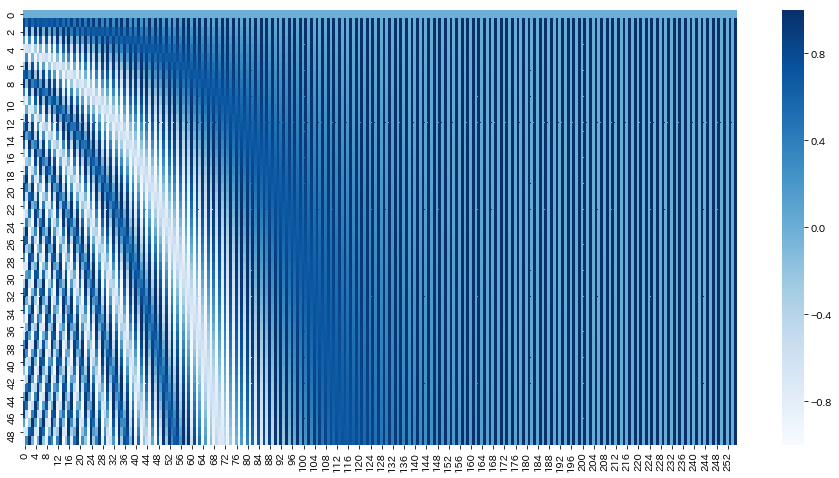

In [11]:
pe = position_encoding_init(50, 256).numpy()
plt.figure(figsize=(16, 8))
sns.heatmap(pe, cmap='Blues')
plt.show()

縦軸が単語の位置を、横軸が成分の次元を表しており、濃淡が加算される値です。

ここでは最大系列長を50、隠れ層の次元数を256としました。

### ② Multihead Attention


#### Source-Target-AttentionとSelf-Attention

Attentionは一般に、queryベクトルとkeyベクトルの類似度を求めて、その正規化した重みをvalueベクトルに適用して値を取り出す処理を行います。

一般的な翻訳モデルで用いられるAttentionはSource-Target-Attentionと呼ばれ、この場合queryはDecoderの隠れ状態(Target)、keyはEncoderの隠れ状態（Source）、valueもEncoderの隠れ状態（Source）で表現されるのが一般的です。
モデル全体の図では、右側のDecoderのブロックの中央にあるAttentionがこれに該当します。


Transformerでは、このSource-Target-Attentionに加えて、query、key、valueを同じ系列内で定義するSelf-Attentionの機構を用います。これにより、ある単語位置の出力を求める際にあらゆる位置を参照できるため、局所的な位置しか参照できない畳み込み層よりも良い性能を発揮できると言われています。
モデル全体の図では、左側のEncoderブロックと右側のDecoderのブロックの下部にあるAttentionがこれに該当します。

<img src="../images/Attention.png" style="width:80%">

Transformerでは、Scaled Dot-Product Attentionと呼ばれるAttentionを、複数のヘッドで並列に行うMulti-Head Attentionによって、Source-Target-AttentionとSelf-Attentionを表現します。

以下では、Scaled Dot-Product AttentionとMulti-Head Attentionについて順に説明していきます。

#### Scaled Dot-Product Attention
Attentionには、注意の重みを隠れ層 1 つのフィードフォワードネットワークで求めるAdditive Attentionと、注意の重みを内積で求めるDot-Product Attentionが存在します。  一般に、Dot-Product Attentionのほうがパラメータが少なく高速であり、Transformerでもこちらを使います。


Tranformerではさらなる工夫として、query($Q$)とkey($K$)の内積をスケーリング因子 $\sqrt{d_k}$ で除算します。

$Attention(Q, K, V) = softmax(\frac{QK^T}{\sqrt{d_k}})V$ 


これは、$d_k$（keyベクトルの次元数）が大きい場合に内積が大きくなりすぎて逆伝播のsoftmaxの勾配が極端に小さくなることを防ぐ役割を果たします。

<img src="../images/Multihead.png" style="height: 400px">

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, attn_dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param attn_dropout: float, ドロップアウト率
        """
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)  # スケーリング因子
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, attn_mask):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(n_head*batch_size, len_q, d_k)
        :param k: torch.tensor, key, 
            size=(n_head*batch_size, len_k, d_k)
        :param v: torch.tensor, valueベクトル, 
            size=(n_head*batch_size, len_v, d_v)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(n_head*batch_size, len_q, len_k)
        :return output: 出力ベクトル, 
            size=(n_head*batch_size, len_q, d_v)
        :return attn: Attention
            size=(n_head*batch_size, len_q, len_k)
        """
        # QとKの内積(上図右側`MatMul`)でAttentionの重みを求め、スケーリングする(上図右側`Scale`)
        attn = # WRITE ME! Hint: torch.bmmを使う (n_head*batch_size, len_q, len_k)
        # Attentionをかけたくない部分がある場合は、その部分を負の無限大に飛ばしてSoftmaxの値が0になるようにする(上図右側`Mask(opt.)`)
        attn.data.masked_fill_(attn_mask, -float('inf'))
        
        attn = self.softmax(attn)  # (上図右側`SoftMax`)
        attn = self.dropout(attn)
        output = # WRITE ME! attnとVの内積を計算 (上図右側`MatMul`)

        return output, attn

#### Multi-Head Attention
TransformerではAttentionを複数のヘッドで並列に行うMulti-Head Attentionを採用しています。

複数のヘッドでAttentionを行うことにより、各ヘッドが異なる位置の異なる部分空間を処理でき、精度が向上するとされています。

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        """
        :param n_head: int, ヘッド数
        :param d_model: int, 隠れ層の次元数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        # 各ヘッドごとに異なる重みで線形変換を行うための重み
        # nn.Parameterを使うことで、Moduleのパラメータとして登録できる
        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.w_qs)
        nn.init.xavier_normal_(self.w_ks)
        nn.init.xavier_normal_(self.w_vs)

        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.proj = nn.Linear(n_head*d_v, d_model)  # 複数ヘッド分のAttentionの結果を元のサイズに写像するための線形層
        # nn.init.xavier_normal_で重みの値を初期化
        nn.init.xavier_normal_(self.proj.weight)
        
        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, attn_mask=None):
        """
        :param q: torch.tensor, queryベクトル, 
            size=(batch_size, len_q, d_model)
        :param k: torch.tensor, key, 
            size=(batch_size, len_k, d_model)
        :param v: torch.tensor, valueベクトル, 
            size=(batch_size, len_v, d_model)
        :param attn_mask: torch.tensor, Attentionに適用するマスク, 
            size=(batch_size, len_q, len_k)
        :return outputs: 出力ベクトル, 
            size=(batch_size, len_q, d_model)
        :return attns: Attention
            size=(n_head*batch_size, len_q, len_k)
            
        """
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        # residual connectionのための入力
        residual = q

        batch_size, len_q, d_model = q.size()
        batch_size, len_k, d_model = k.size()
        batch_size, len_v, d_model = v.size()

        # 複数ヘッド化
        # torch.repeat または .repeatで指定したdimに沿って同じテンソルを作成
        q_s = q.repeat(n_head, 1, 1) # (n_head*batch_size, len_q, d_model)
        k_s = k.repeat(n_head, 1, 1) # (n_head*batch_size, len_k, d_model)
        v_s = v.repeat(n_head, 1, 1) # (n_head*batch_size, len_v, d_model)
        # ヘッドごとに並列計算させるために、n_headをdim=0に、batch_sizeをdim=1に寄せる
        q_s = q_s.view(n_head, -1, d_model) # (n_head, batch_size*len_q, d_model)
        k_s = k_s.view(n_head, -1, d_model) # (n_head, batch_size*len_k, d_model)
        v_s = v_s.view(n_head, -1, d_model) # (n_head, batch_size*len_v, d_model)

        # 各ヘッドで線形変換を並列計算(上図左側`Linear`)
        q_s = torch.bmm(q_s, self.w_qs)  # (n_head, batch_size*len_q, d_k)
        k_s = torch.bmm(k_s, self.w_ks)  # (n_head, batch_size*len_k, d_k)
        v_s = torch.bmm(v_s, self.w_vs)  # (n_head, batch_size*len_v, d_v)
        # Attentionは各バッチ各ヘッドごとに計算させるためにbatch_sizeをdim=0に寄せる
        q_s = q_s.view(-1, len_q, d_k)   # (n_head*batch_size, len_q, d_k)
        k_s = k_s.view(-1, len_k, d_k)   # (n_head*batch_size, len_k, d_k)
        v_s = v_s.view(-1, len_v, d_v)   # (n_head*batch_size, len_v, d_v)

        # Attentionを計算(上図左側`Scaled Dot-Product Attention * h`)
        outputs, attns = self.attention(q_s, k_s, v_s, attn_mask=attn_mask.repeat(n_head, 1, 1))
        # outputs: (n_head*batch_size, len_q, d_v)
        # attns: (n_head*batch_size, len_q, len_k)
        
        # 各ヘッドの結果を連結(上図左側`Concat`)
        # torch.splitでbatch_sizeごとのn_head個のテンソルに分割
        outputs = torch.split(outputs, batch_size, dim=0)  # (batch_size, len_q, d_v) * n_head
        # dim=-1で連結
        outputs = torch.cat(outputs, dim=-1)  # (batch_size, len_q, n_head*d_v)

        # residual connectionのために元の大きさに写像(上図左側`Linear`)
        outputs = self.proj(outputs)  # (batch_size, len_q, d_model)
        outputs = self.dropout(outputs)
        outputs = self.layer_norm(outputs + residual)

        return outputs, attns

### ③ Position-Wise Feed Forward Network
単語列の位置ごとに独立して処理する2層のネットワークであるPosition-Wise Feed Forward Networkを定義します。

In [ ]:
class PositionwiseFeedForward(nn.Module):
    """
    :param d_hid: int, 隠れ層1層目の次元数
    :param d_inner_hid: int, 隠れ層2層目の次元数
    :param dropout: float, ドロップアウト率
    """
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)
        self.layer_norm = nn.LayerNorm(d_hid)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        """
        :param x: torch.tensor,
            size=(batch_size, max_length, d_hid)
        :return: torch.tensor,
            size=(batch_size, max_length, d_hid) 
        """
        residual = x
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return self.layer_norm(output + residual)

### ④ Masking
TransfomerではAttentionに対して2つのマスクを定義します。

一つはkey側の系列のPADトークンに対してAttentionを行わないようにするマスクです。

In [ ]:
def get_attn_padding_mask(seq_q, seq_k):
    """
    keyのPADに対するattentionを0にするためのマスクを作成する
    :param seq_q: tensor, queryの系列, size=(batch_size, len_q)
    :param seq_k: tensor, keyの系列, size=(batch_size, len_k)
    :return pad_attn_mask: tensor, size=(batch_size, len_q, len_k)
    """
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)   # (N, 1, len_k)
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k) # (N, len_q, len_k)
    return pad_attn_mask

In [ ]:
_seq_q = torch.tensor([[1, 2, 3]])
_seq_k = torch.tensor([[4, 5, 6, 7, PAD]])
_mask = get_attn_padding_mask(_seq_q, _seq_k)  # 行がquery、列がkeyに対応し、key側がPAD(=0)の時刻だけ1で他が0の行列ができる
print('query:\n', _seq_q)
print('key:\n', _seq_k)
print('mask:\n', _mask)

もう一つはDecoder側でSelf Attentionを行う際に、各時刻で未来の情報に対するAttentionを行わないようにするマスクです。

In [ ]:
def get_attn_subsequent_mask(seq):
    """
    未来の情報に対するattentionを0にするためのマスクを作成する
    :param seq: tensor, size=(batch_size, length)
    :return subsequent_mask: tensor, size=(batch_size, length, length)
    """
    attn_shape = (seq.size(1), seq.size(1))
    # 上三角行列(diagonal=1: 対角線より上が1で下が0)
    subsequent_mask = torch.triu(torch.ones(attn_shape, dtype=torch.uint8, device=device), diagonal=1)
    subsequent_mask = subsequent_mask.repeat(seq.size(0), 1, 1)
    return subsequent_mask

In [ ]:
# iLectで実行する場合warning (GPU is too old) が出ますが, 実行に問題はないので気にせず進めてください.
_seq = torch.tensor([[1,2,3,4]])
_mask = get_attn_subsequent_mask(_seq)  # 行がquery、列がkeyに対応し、queryより未来のkeyの値が1で他は0の行列ができいる
print('seq:\n', _seq)
print('mask:\n', _mask)  

## 3. モデルの定義

### Encoder
これまで定義してきたサブレイヤーを統合して、Encoderを定義します。

EncoderではSelf AttentionとPosition-Wise Feed Forward Networkからなるブロックを複数層繰り返すので、ブロックのクラスEncoderLayerを定義した後にEncoderを定義します。

In [ ]:
class EncoderLayer(nn.Module):
    """Encoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(EncoderLayer, self).__init__()
        # Encoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(
            n_head, d_model, d_k, d_v, dropout=dropout)
        # Postionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        """
        :param enc_input: tensor, Encoderの入力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attn: tensor, EncoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてEncoderの入力（enc_input）が入る
        enc_output, enc_slf_attn = self.slf_attn(
            enc_input, enc_input, enc_input, attn_mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

In [ ]:
class Encoder(nn.Module):
    """EncoderLayerブロックからなるEncoderのクラス"""
    def __init__(
            self, n_src_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Encoder, self).__init__()

        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=PAD)

        # EncoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):
        """
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, max_length)
        :param src_pos: tensor, 入力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :return enc_output: tensor, Encoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return enc_slf_attns: list, EncoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        enc_input = self.src_word_emb(src_seq)
        # Positional EncodingのEmbeddingを加算する
        enc_input += self.position_enc(src_pos)

        enc_slf_attns = []
        enc_output = enc_input
        # key(=enc_input)のPADに対応する部分のみ1のマスクを作成
        enc_slf_attn_mask = get_attn_padding_mask(src_seq, src_seq)

        # n_layers個のEncoderLayerに入力を通す
        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(
                enc_output, slf_attn_mask=enc_slf_attn_mask)
            enc_slf_attns += [enc_slf_attn]

        return enc_output, enc_slf_attns

### Decoder

Deocoderも同様にSelf Attention, Source-Target Attention, Position-Wise Feed Forward Networkからなるブロックを複数層繰り返ので、ブロックのクラスDecoderLayerを定義した後にDecoderを定義します。

In [ ]:
class DecoderLayer(nn.Module):
    """Decoderのブロックのクラス"""
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        """
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param dropout: float, ドロップアウト率
        """
        super(DecoderLayer, self).__init__()
        # Decoder内のSelf-Attention
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Encoder-Decoder間のSource-Target Attention
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        # Positionwise FFN
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        """
        :param dec_input: tensor, Decoderの入力, 
            size=(batch_size, max_length, d_model)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :param slf_attn_mask: tensor, Self Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :param dec_enc_attn_mask: tensor, Soutce-Target Attentionの行列にかけるマスク, 
            size=(batch_size, len_q, len_k)
        :return dec_output: tensor, Decoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attn: tensor, DecoderのSelf Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        :return dec_enc_attn: tensor, DecoderのSoutce-Target Attentionの行列, 
            size=(n_head*batch_size, len_q, len_k)
        """
        # Self-Attentionのquery, key, valueにはすべてDecoderの入力（dec_input）が入る
        dec_output, dec_slf_attn = # WRITE ME!
        
        # Source-Target AttentionのqueryにはDecoderの出力(dec_output), key, valueにはEncoderの出力（enc_output）が入る
        dec_output, dec_enc_attn = # WRITE ME!
        
        # Positionwise FFNに通す
        dec_output = # WRITE ME!

        return dec_output, dec_slf_attn, dec_enc_attn

In [ ]:
class Decoder(nn.Module):
    """DecoderLayerブロックからなるDecoderのクラス"""
    def __init__(
            self, n_tgt_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        """
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        """
        super(Decoder, self).__init__()
        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        # Positional Encodingを用いたEmbedding
        self.position_enc = nn.Embedding(
            n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        # 一般的なEmbedding
        self.tgt_word_emb = nn.Embedding(
            n_tgt_vocab, d_word_vec, padding_idx=PAD)
        self.dropout = nn.Dropout(dropout)

        # DecoderLayerをn_layers個積み重ねる
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout)
            for _ in range(n_layers)])

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_output):
        """
        :param tgt_seq: tensor, 出力系列, 
            size=(batch_size, max_length)
        :param tgt_pos: tensor, 出力系列の各単語の位置情報,
            size=(batch_size, max_length)
        :param src_seq: tensor, 入力系列, 
            size=(batch_size, n_src_vocab)
        :param enc_output: tensor, Encoderの出力, 
            size=(batch_size, max_length, d_model)
        :return dec_output: tensor, Decoderの最終出力, 
            size=(batch_size, max_length, d_model)
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト 
        :return dec_slf_attns: list, DecoderのSelf Attentionの行列のリスト
        """
        # 一般的な単語のEmbeddingを行う
        dec_input = self.tgt_word_emb(tgt_seq)
        # Positional EncodingのEmbeddingを加算する
        dec_input += self.position_enc(tgt_pos)

        # Self-Attention用のマスクを作成
        # key(=dec_input)のPADに対応する部分が1のマスクと、queryから見たkeyの未来の情報に対応する部分が1のマスクのORをとる
        dec_slf_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)  # (N, max_length, max_length)
        dec_slf_attn_mask = torch.gt(dec_slf_attn_pad_mask + dec_slf_attn_sub_mask, 0)  # ORをとる

        # key(=dec_input)のPADに対応する部分のみ1のマスクを作成
        dec_enc_attn_pad_mask = get_attn_padding_mask(tgt_seq, src_seq)  # (N, max_length, max_length)

        dec_slf_attns, dec_enc_attns = [], []

        dec_output = dec_input
        # n_layers個のDecoderLayerに入力を通す
        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                slf_attn_mask=dec_slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_pad_mask)

            dec_slf_attns += [dec_slf_attn]
            dec_enc_attns += [dec_enc_attn]

        return dec_output, dec_slf_attns, dec_enc_attns

### Transformer
最後にモデル全体の機構を定義します。

In [ ]:
class Transformer(nn.Module):
    """Transformerのモデル全体のクラス"""
    def __init__(
            self, n_src_vocab, n_tgt_vocab, max_length, n_layers=6, n_head=8,
            d_word_vec=512, d_model=512, d_inner_hid=1024, d_k=64, d_v=64,
            dropout=0.1, proj_share_weight=True):
        """
        :param n_src_vocab: int, 入力言語の語彙数
        :param n_tgt_vocab: int, 出力言語の語彙数
        :param max_length: int, 最大系列長
        :param n_layers: int, レイヤー数
        :param n_head: int,　ヘッド数
        :param d_k: int, keyベクトルの次元数
        :param d_v: int, valueベクトルの次元数
        :param d_word_vec: int, 単語の埋め込みの次元数
        :param d_model: int, 隠れ層の次元数
        :param d_inner_hid: int, Position Wise Feed Forward Networkの隠れ層2層目の次元数
        :param dropout: float, ドロップアウト率        
        :param proj_share_weight: bool, 出力言語の単語のEmbeddingと出力の写像で重みを共有する        
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(
            n_src_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.decoder = Decoder(
            n_tgt_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.tgt_word_proj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_proj.weight)
        self.dropout = nn.Dropout(dropout)

        assert d_model == d_word_vec  # 各モジュールの出力のサイズは揃える

        if proj_share_weight:
            # 出力言語の単語のEmbeddingと出力の写像で重みを共有する
            assert d_model == d_word_vec
            self.tgt_word_proj.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        # Positional Encoding以外のパラメータを更新する
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        src_seq = src_seq[:, 1:]
        src_pos = src_pos[:, 1:]
        tgt_seq = tgt_seq[:, :-1]
        tgt_pos = tgt_pos[:, :-1]

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output, *_ = self.decoder(tgt_seq, tgt_pos, src_seq, enc_output)
        seq_logit = self.tgt_word_proj(dec_output)

        return seq_logit

## 4. 学習

In [ ]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    # バッチの損失を計算
    model.train(is_train)
    
    pred_Y = model(batch_X, batch_Y)
    gold = batch_Y[0][:, 1:].contiguous()
    loss = criterion(pred_Y.view(-1, pred_Y.size(2)), gold.view(-1))

    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    gold = gold.data.cpu().numpy().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().tolist()

    return loss.item(), gold, pred

In [ ]:
MAX_LENGTH = 20
batch_size = 64
num_epochs = 15
lr = 0.001
ckpt_path = 'transformer.pth'
max_length = MAX_LENGTH + 2

In [ ]:
model_args = {
    'n_src_vocab': vocab_size_X,
    'n_tgt_vocab': vocab_size_Y,
    'max_length': max_length,
    'proj_share_weight': True,
    'd_k': 32,
    'd_v': 32,
    'd_model': 128,
    'd_word_vec': 128,
    'd_inner_hid': 256,
    'n_layers': 3,
    'n_head': 6,
    'dropout': 0.1,
}

In [ ]:
# DataLoaderやモデルを定義
train_dataloader = DataLoader(
    train_X, train_Y, batch_size
    )
valid_dataloader = DataLoader(
    valid_X, valid_Y, batch_size, 
    shuffle=False
    )

model = Transformer(**model_args).to(device)

optimizer = optim.Adam(model.get_trainable_parameters(), lr=lr)

criterion = nn.CrossEntropyLoss(ignore_index=PAD, reduction='sum').to(device)

In [ ]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(EOS)]] for ref in refs]
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [ ]:
# 訓練
best_valid_bleu = 0.

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(
            batch_X, batch_Y, model, criterion, is_train=False
            )
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred
    # 損失をサンプル数で割って正規化
    train_loss /= len(train_dataloader.data) 
    valid_loss /= len(valid_dataloader.data) 
    # BLEUを計算
    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    # validationデータでBLEUが改善した場合にはモデルを保存
    if valid_bleu > best_valid_bleu:
        ckpt = model.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    elapsed_time = (time.time()-start) / 60
    print('Epoch {} [{:.1f}min]: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu))
    print('-'*80)

## 5. 評価

In [ ]:
def test(model, src, max_length=20):
    # 学習済みモデルで系列を生成する
    model.eval()
    
    src_seq, src_pos = src
    batch_size = src_seq.size(0)
    enc_output, enc_slf_attns = model.encoder(src_seq, src_pos)
        
    tgt_seq = torch.full([batch_size, 1], BOS, dtype=torch.long, device=device)
    tgt_pos = torch.arange(1, dtype=torch.long, device=device)
    tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    # 時刻ごとに処理
    for t in range(1, max_length+1):
        dec_output, dec_slf_attns, dec_enc_attns = model.decoder(
            tgt_seq, tgt_pos, src_seq, enc_output)
        dec_output = model.tgt_word_proj(dec_output)
        out = dec_output[:, -1, :].max(dim=-1)[1].unsqueeze(1)
        # 自身の出力を次の時刻の入力にする
        tgt_seq = torch.cat([tgt_seq, out], dim=-1)
        tgt_pos = torch.arange(t+1, dtype=torch.long, device=device)
        tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    return tgt_seq[:, 1:], enc_slf_attns, dec_slf_attns, dec_enc_attns

In [ ]:
def ids_to_sentence(vocab, ids):
    # IDのリストを単語のリストに変換する
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    # IDのリストからEOS以降の単語を除外する
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [ ]:
# 学習済みモデルの読み込み
model = Transformer(**model_args).to(device)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)

In [ ]:
# テストデータの読み込み
test_X = load_data('../data/dev.en')
test_Y = load_data('../data/dev.ja')
test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

### 生成

In [ ]:
test_dataloader = DataLoader(
    test_X, test_Y, 1,
    shuffle=False
    )

In [ ]:
src, tgt = next(test_dataloader)

src_ids = src[0][0].cpu().numpy()
tgt_ids = tgt[0][0].cpu().numpy()

print('src: {}'.format(' '.join(ids_to_sentence(vocab_X, src_ids[1:-1]))))
print('tgt: {}'.format(' '.join(ids_to_sentence(vocab_Y, tgt_ids[1:-1]))))

preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
print('out: {}'.format(' '.join(ids_to_sentence(vocab_Y, trim_eos(pred_ids)))))

### BLEUの評価

In [ ]:
# BLEUの評価
test_dataloader = DataLoader(
    test_X, test_Y, 128,
    shuffle=False
    )
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y = batch
    preds, *_ = test(model, batch_X)
    preds = preds.data.cpu().numpy().tolist()
    refs = batch_Y[0].data.cpu().numpy()[:, 1:].tolist()
    refs_list += refs
    hyp_list += preds
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

### 4.2 Attentionの可視化

学習済みモデルのAttentionを可視化します。

以下は元論文の図で、Encoder側のあるレイヤーにおけるSelf-Attentionを可視化したものです。

異なる色が異なるヘッドを、色の濃淡がAttentionの重みを表しており、各ヘッドが異なる位置へのAttentionを担っていることがわかります。

<img src="../images/AttentionVisualization.png" style="height:400px">

以下ではもう少し単純に、各行をquery、各列をkeyとしてAttentionの行列を可視化します。

モデルはEncoder/Decoderそれぞれが複数のレイヤーを有し、各レイヤー内の各Attentionも複数のヘッドを有するので、順番に中身を可視化していきます。

In [ ]:
def show_attentions(attention, sent_q, sent_k, n_max=10):
    # Attentionの行列を可視化する(n_maxは表示するヘッドの最大数)
    # EOS以降を削除
    q_eos = sent_q.index(EOS_TOKEN)
    k_eos = sent_k.index(EOS_TOKEN)
    sent_q = sent_q[:q_eos+1]
    sent_k = sent_k[:k_eos+1]
    
    n_head = attention.size(0)
    n_head = min(n_head, n_max)
    fig, axes = plt.subplots(1, n_head, figsize=(20, 8))
    for h in range(n_head):
        data = attention[h].cpu().data[:q_eos+1, :k_eos+1]
        x = sent_k
        y = sent_q if h == 0 else []
        sns.heatmap(data, vmin=0., vmax=1., cbar=False, ax=axes[h], cmap='Blues')
        axes[h].set_xticklabels(x)
        axes[h].set_yticklabels(y, rotation=0)
    plt.show()

In [ ]:
sns.set_context('poster')

In [ ]:
src_sent = [vocab_X.id2word[i] for i in src_ids[1:]]
pred_sent = [vocab_Y.id2word[i] for i in pred_ids]

#### Encoder Self Attention

In [ ]:
# 1st layer
show_attentions(enc_slf_attns[0], src_sent, src_sent, 3)

In [ ]:
# 2nd layer
show_attentions(enc_slf_attns[1], src_sent, src_sent, 3)

In [ ]:
# 3rd layer
show_attentions(enc_slf_attns[2], src_sent, src_sent, 3)

#### Decoder Self Attention

In [ ]:
# 1st layer
show_attentions(dec_slf_attns[0], pred_sent, pred_sent, 3)

In [ ]:
# 2nd layer
show_attentions(dec_slf_attns[1], pred_sent, pred_sent, 3)

In [ ]:
# 3rd layer
show_attentions(dec_slf_attns[2], pred_sent, pred_sent, 3)

#### Encoder Decoder Attention

In [ ]:
# 1st layer
show_attentions(dec_enc_attns[0], pred_sent, src_sent, 3)

In [ ]:
# 2nd layer
show_attentions(dec_enc_attns[1], pred_sent, src_sent, 3)

In [ ]:
# 3rd layer
show_attentions(dec_enc_attns[2], pred_sent, src_sent, 3)